# CNN

In [1]:
import tensorflow as tf
from tensorflow import keras
import stella
import glob
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
%load_ext tensorboard
print(tf.config.list_physical_devices())

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]


/Users/azib/micromamba/envs/nets2/lib/python3.8/site-packages/lightkurve/config/__init__.py:119: UserWarning: The default Lightkurve cache directory, used by download(), etc., has been moved to /Users/azib/.lightkurve/cache. Please move all the files in the legacy directory /Users/azib/.lightkurve-cache to the new location and remove the legacy directory. Refer to https://docs.lightkurve.org/reference/config.html#default-cache-directory-migration for more information.
  warnings.warn(


In [2]:
cadences = 168

In [3]:
# exoplanets = stella.FlareDataSet(fn_dir='/Users/azib/Documents/open_source/nets2/models/exoplanets1k/',
#                          catalog='/Users/azib/Documents/open_source/nets2/catalogs/exoplanets1k.txt',cadences=cadences,frac_balance=1)

In [4]:
# fbinaries = stella.FlareDataSet(fn_dir='/Users/azib/Documents/open_source/nets2/models/binaries1k/',
#                          catalog='/Users/azib/Documents/open_source/nets2/catalogs/fakebinaries1k.txt',frac_balance=1,cadences=cadences)

In [5]:
# exocomets_extra = stella.FlareDataSet(fn_dir='/Users/azib/Documents/open_source/nets2/models/comets20k/',
#                          catalog='/Users/azib/Documents/open_source/nets2/catalogs/comets20k.txt',cadences=cadences,frac_balance=1)

In [6]:
# rbinaries = stella.FlareDataSet(fn_dir='/Users/azib/Documents/open_source/nets2/models/binaries-s7/',
#                          catalog='/Users/azib/Documents/open_source/nets2/catalogs/binaries-catalog-s7.txt',cadences=cadences,frac_balance=1)

In [7]:
# ds = stella.FlareDataSet(fn_dir='/Users/azib/Documents/open_source/nets2/models/comets10k-newmodel/',
#                          catalog='/Users/azib/Documents/open_source/nets2/catalogs/comets10k-newmodel.txt',cadences=cadences,training=0.8,validation=0.1,frac_balance=0.26 , merge_datasets=True,other_datasets = [exoplanets,fbinaries,rbinaries,exocomets_extra],other_datasets_labels = [2,3,4,1] )

In [8]:
ds = stella.FlareDataSet(fn_dir='/Users/azib/Documents/open_source/nets2/models/comets15k-cometcurve2/',
                         catalog='/Users/azib/Documents/open_source/nets2/catalogs/comets15k-cometcurve2.txt',cadences=cadences,training=0.8,validation=0.15,frac_balance=0.65)

Reading in training set files.


100%|█████████████████| 15271/15271 [00:03<00:00, 4090.27it/s]


Number of positive class training data: 12216
Number of negative class training data: 12182
Number of positive class validation data: 2291
Number of negative class validation data: 2284
Size of augmented data (training set only): 0
Class label (training): 0, Count: 12182
Class label (training): 1, Count: 12216
Class label (validation): 0, Count: 2284
Class label (validation): 1, Count: 2291
Total size of training set: 24398
Total size of validation set: 4575
Total size of test set: 1525
Approximate class imbalance: -0.0



## Training Data Plots

12216 positive class in training set
12182 true negative class in training set


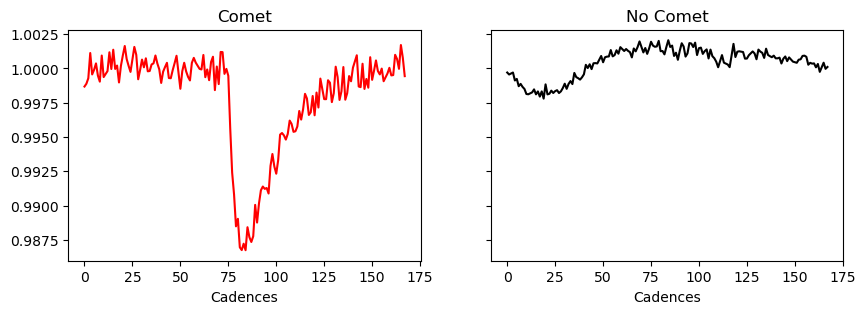

In [9]:
m = 108
ind_pc = np.where(ds.train_labels==1)[0] 
ind_nc = np.where(ds.train_labels!=1)[0] 
print(len(ind_pc),"positive class in training set")
print(len(ind_nc),"true negative class in training set")

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10,3),
                               sharex=True, sharey=True)
ax1.plot(ds.train_data[ind_pc[m]], 'r')
ax1.set_title('Comet')
ax1.set_xlabel('Cadences')
ax2.plot(ds.train_data[ind_nc[m]], 'k')
ax2.set_title('No Comet')
ax2.set_xlabel('Cadences');

## Training Data Imbalance

In [10]:
print(f"{np.round(100 * len(ind_pc) / len(ind_nc))}% class imbalance")
print(len(ind_pc), "positive class")
print(len(ind_nc), "negative class")

100.0% class imbalance
12216 positive class
12182 negative class


## Validation data plots

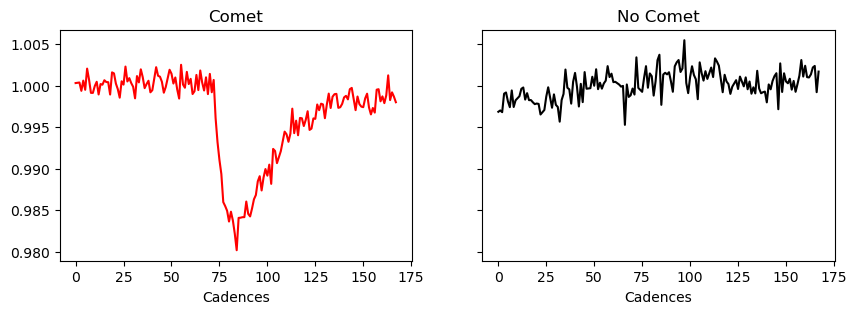

In [11]:
val_pc = np.where(ds.val_labels==1)[0] 
val_nc = np.where(ds.val_labels!=1)[0] 


fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10,3),
                               sharex=True, sharey=True)
ax1.plot(ds.val_data[val_pc[1]], 'r')
ax1.set_title('Comet')
ax1.set_xlabel('Cadences')
ax2.plot(ds.val_data[val_nc[-1]], 'k')
ax2.set_title('No Comet')
ax2.set_xlabel('Cadences');

In [12]:
print(f"{np.round(100 * len(val_pc) / len(val_nc))}% class imbalance")
print(len(val_pc), "positive class")
print(len(val_nc), "negative class")

100.0% class imbalance
2291 positive class
2284 negative class


In [13]:
# dsmodels = ds.train_data[ind_nc]

# num_sets = dsmodels.shape[0] // 100

# for set_index in range(num_sets):
#     start_index = set_index * 100
#     end_index = min((set_index + 1) * 100, dsmodels.shape[0])  # Ensure not to exceed the length of the data

#     # Create a new 10x10 grid of subplots for each set
#     fig, axs = plt.subplots(10, 10, figsize=(20, 20))

#     # Flatten the axes array for easier iteration
#     axs = axs.flatten()

#     # Iterate over the elements in the current set and plot each in the grid
#     for i in range(start_index, end_index):
#         plot_index = i % 100  # Calculate the index within the current grid
#         axs[plot_index].plot(dsmodels[i, :, 0])  # Assuming you want to plot the first dimension of your array
#         axs[plot_index].set_title(f"Plot {i}")  # Title for each subplot

#     # Hide any remaining empty subplots
#     for j in range(end_index - start_index, len(axs)):
#         axs[j].axis('off')

    
#     plt.tight_layout()  # Adjust layout
#     #plt.savefig(f'example-models{start_index}-{end_index}.png',dpi=200,bbox_inches='tight')
#     plt.show()  # Show the grid of plots
#     break

In [14]:
filter1 = 8
filter2 = 64
filter3 = 128
kernel_size1 = 7
kernel_size2 = 7
kernel_size3 = 3
pool_size = 2
dropout = 0.1
dense = 32
l2val = 0.001
input_shape = (cadences, 1)
alpha = 0.1  # Leaky ReLU parameter

layers = [
    tf.keras.layers.Conv1D(filters=filter1, kernel_size=kernel_size1, padding="same", activation='relu', input_shape=input_shape),
    tf.keras.layers.MaxPooling1D(pool_size=pool_size),
    tf.keras.layers.Dropout(dropout),
    
    #tf.keras.layers.Conv1D(filters=filter2, kernel_size=kernel_size2, padding="same", activation='relu'),
    # tf.keras.layers.LeakyReLU(alpha=alpha),
    #tf.keras.layers.MaxPooling1D(pool_size=pool_size),
    #tf.keras.layers.Dropout(dropout),

    # Uncomment these lines if you want to include the third Conv1D layer with Leaky ReLU
    # tf.keras.layers.Conv1D(filters=filter3, kernel_size=kernel_size3, padding="same", kernel_regularizer=tf.keras.regularizers.l2(l2val), activation=None),
    # tf.keras.layers.LeakyReLU(alpha=alpha),
    # tf.keras.layers.BatchNormalization(),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(dense, activation='relu'),  # , kernel_regularizer=tf.keras.regularizers.l2(l2val)),
    tf.keras.layers.Dropout(dropout),
    tf.keras.layers.Dense(1, activation="sigmoid")]

In [15]:
cnn = stella.ConvNN(output_dir='/Users/azib/Documents/open_source/nets2/cnn-models/',ds=ds) #,layers=layers)
SEED = [6]

In [ ]:
#%tensorboard --logdir './logs'
cnn.train_models(seeds=SEED, epochs=50,batch_size=128,shuffle=True)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 168, 16)           128       
                                                                 
 max_pooling1d (MaxPooling1  (None, 84, 16)            0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 84, 16)            0         
                                                                 
 conv1d_1 (Conv1D)           (None, 84, 64)            3136      
                                                                 
 max_pooling1d_1 (MaxPoolin  (None, 42, 64)            0         
 g1D)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 42, 64)            0

In [ ]:
from matplotlib import cm
import matplotlib.colors as mcolors
import numpy as np

if type(SEED) == list:
    for seeds in SEED:
        # Create a custom colormap
        custom_cmap = mcolors.ListedColormap(['yellow', 'darkblue', 'red','cyan'])

        fig, axes = plt.subplots(2, 2, figsize=(13,8))
        formatted_seed = f'{seeds:04}'

        # Plot ground truth
        sc = axes[0, 0].scatter(cnn.val_pred_table['tpeak'], cnn.val_pred_table[f'pred_s{formatted_seed}'],
                                c=cnn.val_pred_table['labels'], cmap=custom_cmap, label=f'Seed {formatted_seed}',s=10)
        axes[0, 0].set_xlabel('Tpeak [BJD - 2457000]')
        axes[0, 0].set_ylabel('Probability of Exocomet')
        axes[0,0].set_title('Probabilities (with the original labels)')
        plt.colorbar(sc, ax=axes[0, 0], ticks=np.arange(4), boundaries=np.arange(4+1)-0.5)

        # Plot loss
        axes[1, 1].plot(cnn.history_table[f'loss_s{formatted_seed}'], label=f'Training Seed {formatted_seed}', lw=3)
        axes[1, 1].plot(cnn.history_table[f'val_loss_s{formatted_seed}'], label=f'Validation Seed {formatted_seed}', lw=3)
        axes[1, 1].set_xlabel('Epochs')
        axes[1, 1].set_ylabel('Loss')
        axes[1,1].set_title('Loss')
        axes[1, 1].legend()

        # Plot accuracy
        axes[1, 0].plot(cnn.history_table[f'accuracy_s{formatted_seed}'], label=f'Training Seed {formatted_seed}', lw=3)
        axes[1, 0].plot(cnn.history_table[f'val_accuracy_s{formatted_seed}'], label=f'Validation Seed {formatted_seed}', lw=3)
        axes[1, 0].set_xlabel('Epochs')
        axes[1, 0].set_ylabel('Accuracy')
        axes[1, 0].set_title('Accuracy')
        axes[1, 0].legend()

        # Plot ground truth (gt)
        sc2 = axes[0, 1].scatter(cnn.val_pred_table['tpeak'], cnn.val_pred_table[f'pred_s{formatted_seed}'],
                                 c=cnn.val_pred_table['gt'], label=f'Seed {formatted_seed}')
        axes[0, 1].set_xlabel('Tpeak [BJD - 2457000]')
        axes[0, 1].set_ylabel('Probability of Exocomet')
        axes[0,1].set_title('Probabilities')
        plt.colorbar(sc2, ax=axes[0, 1])#, ticks=np.arange(2)#, boundaries=np.arange(2)-0.5)
    
        plt.tight_layout()
        plt.savefig(f'../metrics-{SEED}.png',dpi=300,bbox_inches='tight')
        plt.show()

Colour plot with SNR value

---

## Predict on Real Lightcurves

In [18]:
import sys
sys.path.insert(1,'/Users/azib/Documents/open_source/nets2/stella')
sys.path.insert(1,'/Users/azib/Documents/open_source/nets2/scripts')
from utils import *
import lightkurve as lk

In [19]:
files = glob.glob('../data/272-candidates/*')

In [20]:
modelname = '../cnn-models/ensemble_s0005_i0050_b0.65.h5'

In [21]:
lc = lk.search_lightcurve('Beta Pic',mission='TESS',sector=6)[1].download()

In [22]:
cnn.predict(modelname=modelname,
            times=lc.time.value,
            fluxes=lc.flux.value,
            errs=lc.flux_err.value)

100%|███████████████████████████| 1/1 [00:00<00:00,  6.68it/s]


Text(0, 0.5, 'Normalized Flux')

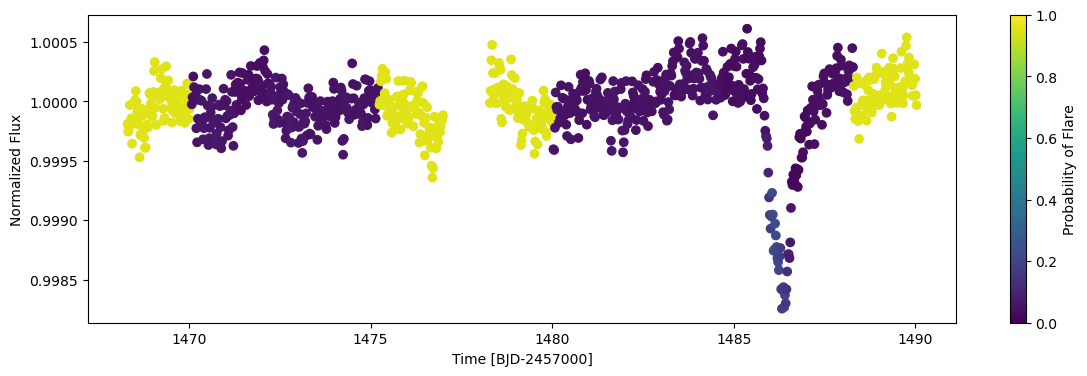

In [23]:
plt.figure(figsize=(14,4))
plt.scatter(cnn.predict_time[0], cnn.predict_flux[0],
            c=cnn.predictions[0], vmin=0, vmax=1)
plt.colorbar(label='Probability of Flare')
#plt.axvline(cnn.predict_time[0][np.argmax(cnn.predictions)],color='red',linestyle='--',zorder=1)
plt.xlabel('Time [BJD-2457000]')
plt.ylabel('Normalized Flux')


In [44]:
cnn.predictions[0].max()

0.99883825

In [45]:
cnn.predict(modelname=modelname,
            times=lc.time.value,
            fluxes=np.flipud(lc.flux.value),
            errs=lc.flux_err.value)

100%|███████████████████████████| 1/1 [00:00<00:00,  7.47it/s]


Text(0, 0.5, 'Normalized Flux')

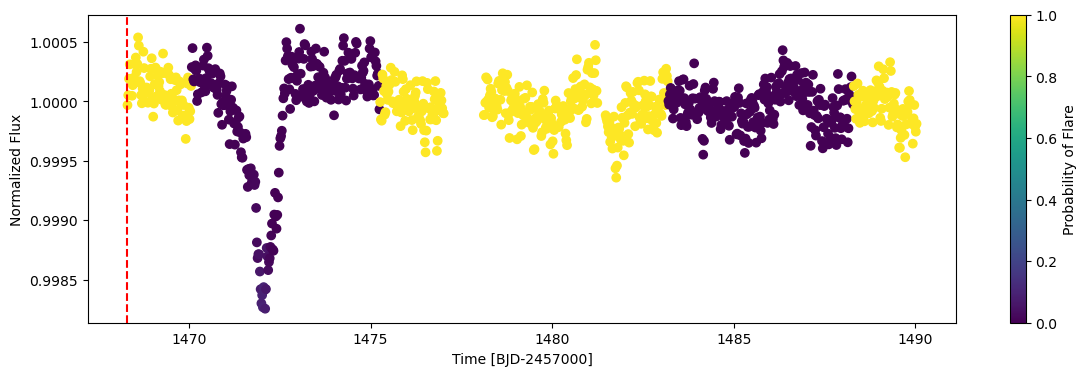

In [33]:
plt.figure(figsize=(14,4))
plt.scatter(cnn.predict_time[0], cnn.predict_flux[0],
            c=cnn.predictions[0], vmin=0, vmax=1)
plt.colorbar(label='Probability of Flare')
plt.axvline(cnn.predict_time[0][np.argmax(cnn.predictions)],color='red',linestyle='--',zorder=1)
plt.xlabel('Time [BJD-2457000]')
plt.ylabel('Normalized Flux')


---